In [ ]:
%pip install fairlearn
%pip install shap
%pip install lime
%pip install mlflow

# Fiarness in ML with fairlearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings

warnings.simplefilter("ignore")

rand_seed = 420
np.random.seed(rand_seed)

Look at credit card data

In [ ]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (
    pd.read_excel(io=data_url, header=1)
    .drop(columns=["ID"])
    .rename(
        columns={"PAY_0": "PAY_1", "default payment next month": "default"}
    )
)

dataset.shape

(30000, 24)

In [ ]:
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
categorical_features = ["SEX", "EDUCATION", "MARRIAGE"]

for col_name in categorical_features:
    dataset[col_name] = dataset[col_name].astype("category")

Y, A = dataset.loc[:, "default"], dataset.loc[:, "SEX"]
X = pd.get_dummies(dataset.drop(columns=["default", "SEX"]))
A_str = A.map({1: "male", 2: "female"})

In [ ]:
print(Y)

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default, Length: 30000, dtype: int64


In [ ]:
A_str.value_counts(normalize=True)

female    0.603733
male      0.396267
Name: SEX, dtype: float64

In [ ]:
Y.value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default, dtype: float64

# Generate synthetic data related to the protected attribute (sex of a applicant)

females wil have higher "interest" compared to males

In [ ]:
X.loc[:, "Interest"] = np.random.normal(loc=2 * Y, scale=A)

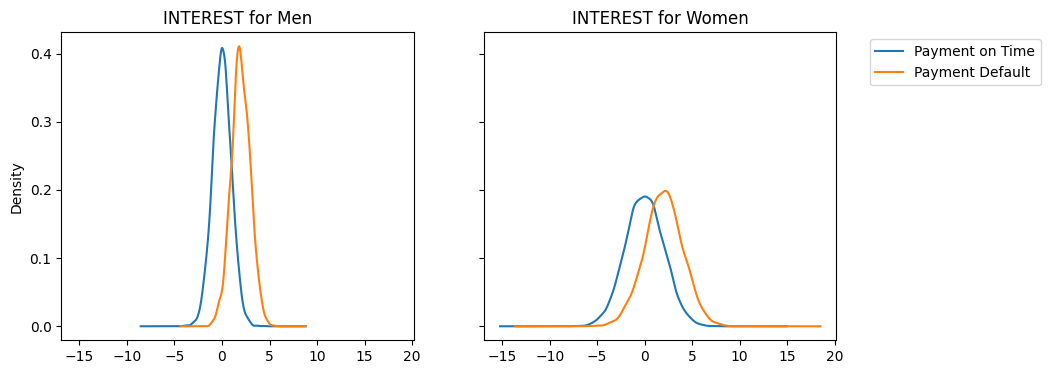

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(
    ncols=2, figsize=(10, 4), sharex=True, sharey=True
)
X["Interest"][(A == 1) & (Y == 0)].plot(
    kind="kde", label="Payment on Time", ax=ax_1, title="INTEREST for Men"
)
X["Interest"][(A == 1) & (Y == 1)].plot(
    kind="kde", label="Payment Default", ax=ax_1
)
X["Interest"][(A == 2) & (Y == 0)].plot(
    kind="kde",
    label="Payment on Time",
    ax=ax_2,
    legend=True,
    title="INTEREST for Women",
)
X["Interest"][(A == 2) & (Y == 1)].plot(
    kind="kde", label="Payment Default", ax=ax_2, legend=True
).legend(bbox_to_anchor=(1.6, 1))

In [ ]:
def resample_training_data(X_train, Y_train, A_train):
    """Down-sample the majority class in the training dataset to produce a
    balanced dataset with a 50/50 split in the predictive labels.

    Parameters:
    X_train: The training split of the features
    Y_train: The training split of the target labels
    A_train: The training split of the sensitive features

    Returns:
    Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    """
    negative_ids = Y_train[Y_train == 0].index # pay on time indeces
    positive_ids = Y_train[Y_train == 1].index # default indeces

    minority_size = len(positive_ids)
    majority_class = negative_ids

    if(len(negative_ids)<len(positive_ids)):
      minority_size = len(negative_ids)
      majority_class = positive_ids

    balanced_ids = positive_ids.union(
        np.random.choice(a=majority_class, size=minority_size)
    )

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

In [ ]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A_str, test_size=0.35, stratify=Y
)

X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

In [ ]:
print(X_train.shape,y_train.shape)

(8626, 32) (8626,)


In [ ]:
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 10,
    "max_depth": 3,
    "random_state": rand_seed,
    "n_jobs": 1,
}

estimator = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("classifier", lgb.LGBMClassifier(**lgb_params)),
    ]
)

estimator.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4313, number of negative: 4313
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3519
[LightGBM] [Info] Number of data points in the train set: 8626, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc',
                                n_jobs=1, num_leaves=10, objective='binary',
                                random_state=420))])

In [ ]:
Y_pred_proba = estimator.predict_proba(X_test)[:, 1]
Y_pred = estimator.predict(X_test)


In [ ]:
roc_auc_score(y_test, Y_pred_proba)

0.8693361854968296

# Get feature importance plot directly from model

<Axes: title={'center': 'Feature Importance'}, xlabel='Feature importance', ylabel='Features'>

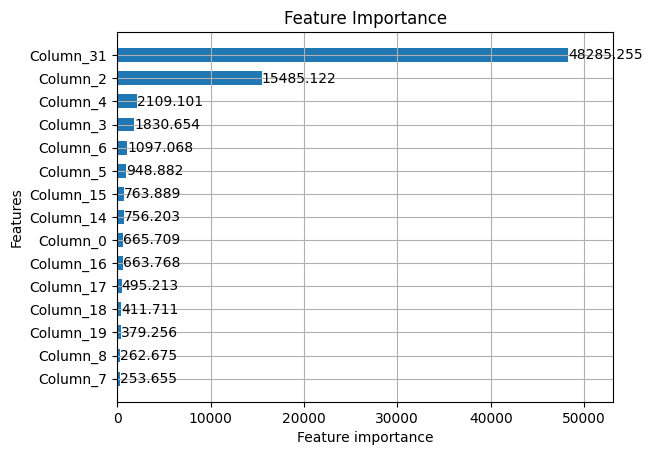

In [ ]:
lgb.plot_importance(
    estimator.named_steps["classifier"],
    height=0.6,
    title="Feature Importance",
    importance_type="gain",
    max_num_features=15,
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("classifier", RandomForestClassifier(max_depth=5, random_state=rand_seed)),
    ]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=420))])

In [ ]:
Y_pred_proba_rnd = clf.predict_proba(X_test)[:, 1]
Y_pred_rnd = clf.predict(X_test)

In [ ]:
roc_auc_score(y_test, Y_pred_proba_rnd)

0.8645305430522316

# Feature importance as a blackbox


In [ ]:
from sklearn.inspection import permutation_importance

def feature_importance(clf, X, y, top_limit=None):

  # Retrieve the Bunch object after 50 repeats
  # n_repeats is the number of times that each feature was permuted to compute the final score
  bunch = permutation_importance(clf, X, y,
                                 n_repeats=50, random_state=rand_seed)
  # Average feature importance
  imp_means = bunch.importances_mean

  # List that contains the index of each feature in descending order of importance
  ordered_imp_means_args = np.argsort(imp_means)[::-1]

  # If no limit print all features
  if top_limit is None:
    top_limit = len(ordered_imp_means_args)

  # Print relevant information
  for i, _ in zip(ordered_imp_means_args, range(top_limit)):
    imp_score = imp_means[i]
    imp_std = bunch.importances_std[i]
    name = X.columns[i]
    print(f"Feature {name} with index {i} has an average importance score of {imp_score:.3f} +/- {imp_std:.3f}\n")

In [ ]:
feature_importance(estimator,X_test,y_test)

Feature Interest with index 31 has an average importance score of 0.136 +/- 0.004

Feature PAY_1 with index 2 has an average importance score of 0.032 +/- 0.002

Feature PAY_3 with index 4 has an average importance score of 0.003 +/- 0.001

Feature PAY_AMT2 with index 15 has an average importance score of 0.003 +/- 0.001

Feature LIMIT_BAL with index 0 has an average importance score of 0.001 +/- 0.001

Feature PAY_AMT3 with index 16 has an average importance score of 0.001 +/- 0.000

Feature PAY_5 with index 6 has an average importance score of 0.001 +/- 0.001

Feature PAY_6 with index 7 has an average importance score of 0.000 +/- 0.000

Feature BILL_AMT5 with index 12 has an average importance score of 0.000 +/- 0.000

Feature BILL_AMT1 with index 8 has an average importance score of 0.000 +/- 0.000

Feature PAY_4 with index 5 has an average importance score of 0.000 +/- 0.001

Feature BILL_AMT3 with index 10 has an average importance score of 0.000 +/- 0.000

Feature MARRIAGE_3 wit

# Explain Predictions

In [ ]:
import lime
import lime.lime_tabular


In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(),feature_names = X.columns,
                                                   categorical_features=categorical_features,
                                                   kernel_width=10, verbose=False,mode='classification')


In [ ]:
np.random.seed(420)

In [ ]:
i = 0
print(A.iloc[i])
exp = explainer.explain_instance(X_test.to_numpy()[i], estimator.predict_proba, num_features=10)
exp.show_in_notebook(show_all=False)

2


In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.Explainer(estimator[-1],X)
shap_values = explainer.shap_values(X_test)

ex = shap.Explanation(shap_values[i],
                      explainer.expected_value,
                      X_test.iloc[i],
                      feature_names=X_test.columns)

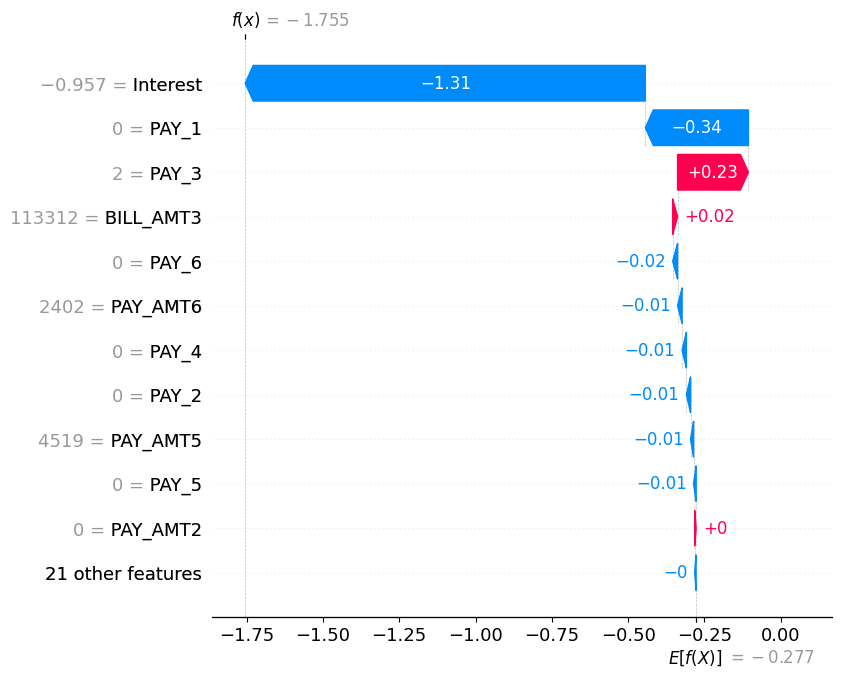

In [ ]:
shap.plots.waterfall(ex, max_display=12, show=True)

In [ ]:
def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )


def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2


fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}


In [ ]:
metrics_to_report = [
    "balanced_accuracy",
    "false_positive_rate",
    "false_negative_rate",
]

In [ ]:
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=Y_pred,
    sensitive_features=A_test,
)

metricframe_unmitigated.by_group[metrics_to_report]

metricframe_unmitigated.difference()[metrics_to_report]

metricframe_unmitigated.overall[metrics_to_report]

balanced_accuracy      0.788589
false_positive_rate    0.220497
false_negative_rate    0.202325
dtype: float64

In [ ]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
    """Plot the disaggregated metric for each group with an associated
    error bar. Both metric and the error bar are provided as columns in the
    provided MetricFrame.

    Parameters
    ----------
    metricframe : MetricFrame
        The MetricFrame containing the metrics and their associated
        uncertainty quantification.
    metric : str
        The metric to plot
    error_name : str
        The associated standard error for each metric in metric

    Returns
    -------
    Matplotlib Plot of point estimates with error bars
    """
    grouped_metrics = metricframe.by_group
    point_estimates = grouped_metrics[metric]
    error_bars = grouped_metrics[error_name]
    lower_bounds = point_estimates - error_bars
    upper_bounds = point_estimates + error_bars

    x_axis_names = [
        str(name) for name in error_bars.index.to_flat_index().tolist()
    ]
    plt.vlines(
        x_axis_names,
        lower_bounds,
        upper_bounds,
        linestyles="dashed",
        alpha=0.45,
    )
    plt.scatter(x_axis_names, point_estimates, s=25)
    plt.xticks(rotation=0)
    y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(
        max(upper_bounds), decimals=2
    )
    plt.yticks(np.arange(y_start, y_end, 0.05))
    plt.ylabel(metric)

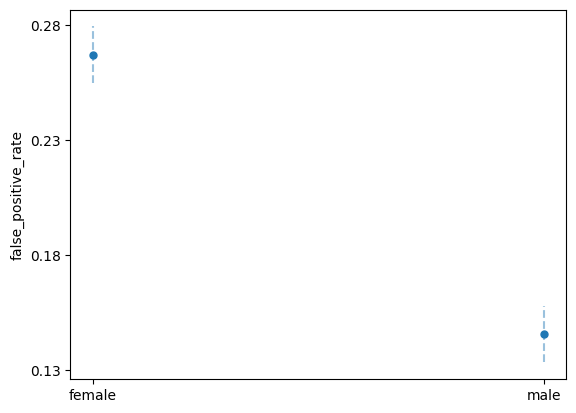

In [ ]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_positive_rate", "false_positive_error"
)

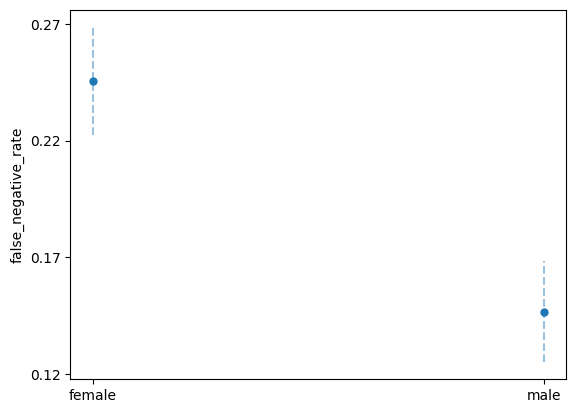

In [ ]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_negative_rate", "false_negative_error"
)

array([[<Axes: title={'center': 'balanced_accuracy'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

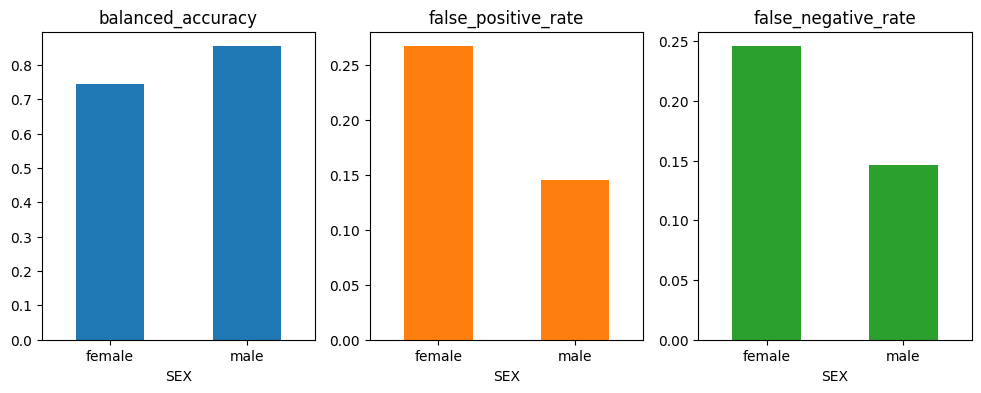

In [ ]:
metricframe_unmitigated.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)


In [ ]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, Y_pred)
equalized_odds_unmitigated = equalized_odds_difference(
    y_test, Y_pred, sensitive_features=A_test
)

In [ ]:
postprocess_est = ThresholdOptimizer(
    estimator=
    ,
    constraints="equalized_odds",  # Optimize FPR and FNR simultaneously
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)

In [ ]:
postprocess_est.fit(X=X_train, y=y_train, sensitive_features=A_train)

postprocess_pred = postprocess_est.predict(X_test, sensitive_features=A_test)

postprocess_pred_proba = postprocess_est._pmf_predict(
    X_test, sensitive_features=A_test
)

In [ ]:
def compare_metricframe_results(mframe_1, mframe_2, metrics, names):
    """Concatenate the results of two MetricFrames along a subset of metrics.

    Parameters
    ----------
    mframe_1: First MetricFrame for comparison
    mframe_2: Second MetricFrame for comparison
    metrics: The subset of metrics for comparison
    names: The names of the selected metrics

    Returns
    -------
    MetricFrame : MetricFrame
        The concatenation of the two MetricFrames, restricted to the metrics
        specified.

    """
    return pd.concat(
        [mframe_1.by_group[metrics], mframe_2.by_group[metrics]],
        keys=names,
        axis=1,
    )

In [ ]:
bal_acc_postprocess = balanced_accuracy_score(y_test, postprocess_pred)
eq_odds_postprocess = equalized_odds_difference(
    y_test, postprocess_pred, sensitive_features=A_test
)

metricframe_postprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=postprocess_pred,
    sensitive_features=A_test,
)

metricframe_postprocess.overall[metrics_to_report]

metricframe_postprocess.difference()[metrics_to_report]

balanced_accuracy      0.010646
false_positive_rate    0.000326
false_negative_rate    0.021618
dtype: float64

array([[<Axes: title={'center': 'balanced_accuracy'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

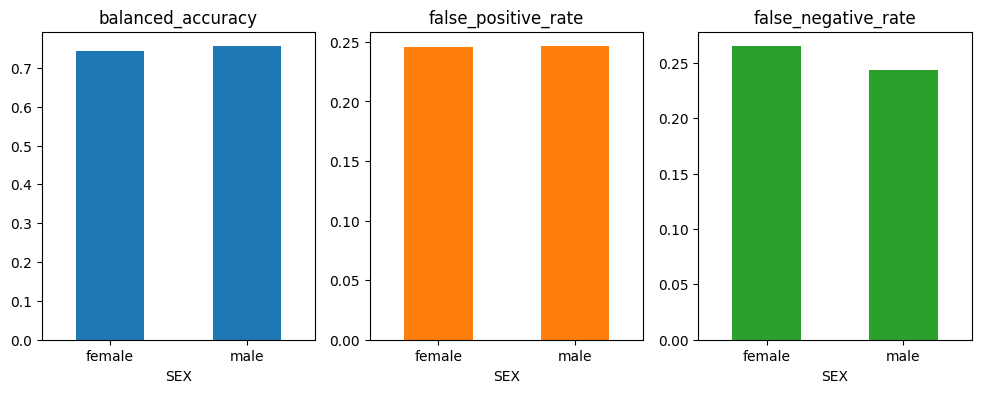

In [ ]:
compare_metricframe_results(
    metricframe_unmitigated,
    metricframe_postprocess,
    metrics=metrics_to_report,
    names=["Unmitigated", "PostProcess"],
)

metricframe_postprocess.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

In [ ]:
def get_expgrad_models_per_epsilon(
    estimator, epsilon, X_train, y_train, A_train
):
    """Instantiate and train an ExponentiatedGradient model on the
    balanced training dataset.

    Parameters
    ----------
    Estimator: Base estimator to contains a fit and predict function.
    Epsilon: Float representing maximum difference bound for the fairness Moment constraint

    Returns
    -------
    Predictors
        List of inner model predictors learned by the ExponentiatedGradient
        model during the training process.

    """
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        sample_weight_name='classifier__sample_weight',
        constraints=EqualizedOdds(difference_bound=epsilon),
    )
    # Is this an issue - Re-runs
    exp_grad_est.fit(X_train, y_train, sensitive_features=A_train)
    predictors = exp_grad_est.predictors_
    return predictors


In [ ]:
epsilons = [0.01, 0.02]

In [ ]:
all_models = {}
for eps in epsilons:
    all_models[eps] = get_expgrad_models_per_epsilon(
        estimator=estimator,
        epsilon=eps,
        X_train=X_train,
        y_train=y_train,
        A_train=A_train,
    )

In [ ]:
for epsilon, models in all_models.items():
    print(
        f"For epsilon {epsilon}, ExponentiatedGradient learned {len(models)} inner models"
    )

For epsilon 0.01, ExponentiatedGradient learned 18 inner models
For epsilon 0.02, ExponentiatedGradient learned 18 inner models


In [ ]:
def is_pareto_efficient(points):
    """Filter a NumPy Matrix to remove rows that are strictly dominated by
    another row in the matrix. Strictly dominated means the all the row values
    are greater than the values of another row.

    Parameters
    ----------
    Points: NumPy array (NxM) of model metrics.
        Assumption that smaller values for metrics are preferred.

    Returns
    -------
    Boolean Array
        Nx1 boolean mask representing the non-dominated indices.
    """
    n, m = points.shape
    is_efficient = np.ones(n, dtype=bool)
    for i, c in enumerate(points):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(
                points[is_efficient] < c, axis=1
            )
            is_efficient[i] = True
    return is_efficient


In [ ]:
def filter_dominated_rows(points):
    """Remove rows from a DataFrame that are monotonically dominated by
    another row in the DataFrame.

    Parameters
    ----------
    Points: DataFrame where each row represents the summarized performance
            (balanced accuracy, fairness metric) of an inner model.

    Returns
    -------
    pareto mask: Boolean mask representing indices of input DataFrame that are not monotonically dominated.
    masked_DataFrame: DataFrame with dominated rows filtered out.

    """
    pareto_mask = is_pareto_efficient(points.to_numpy())
    return pareto_mask, points.loc[pareto_mask, :]


In [ ]:
def aggregate_predictor_performances(
    predictors, metric, X_test, Y_test, A_test=None
):
    """Compute the specified metric for all classifiers in predictors.
    If no sensitive features are present, the metric is computed without
    disaggregation.

    Parameters
    ----------
    predictors: A set of classifiers to generate predictions from.
    metric: The metric (callable) to compute for each classifier in predictor
    X_test: The data features of the testing data set
    Y_test: The target labels of the teting data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    List of performance scores for each classifier in predictors, for the
    given metric.
    """
    all_predictions = [predictor.predict(X_test) for predictor in predictors]
    if A_test is not None:
        return [
            metric(Y_test, Y_sweep, sensitive_features=A_test)
            for Y_sweep in all_predictions
        ]
    else:
        return [metric(Y_test, Y_sweep) for Y_sweep in all_predictions]


In [ ]:
def model_performance_sweep(models_dict, X_test, y_test, A_test):
    """Compute the equalized_odds_difference and balanced_error_rate for a
    given list of inner models learned by the ExponentiatedGradient algorithm.
    Return a DataFrame containing the epsilon level of the model, the index
    of the model, the equalized_odds_difference score and the balanced_error
    for the model.

    Parameters
    ----------
    models_dict: Dictionary mapping model ids to a model.
    X_test: The data features of the testing data set
    y_test: The target labels of the testing data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    DataFrame where each row represents a model (epsilon, index) and its
    performance metrics
    """
    performances = []
    for (eps, models) in models_dict.items():
        eq_odds_difference = aggregate_predictor_performances(
            models, equalized_odds_difference, X_test, y_test, A_test
        )
        bal_acc_score = aggregate_predictor_performances(
            models, balanced_accuracy_score, X_test, y_test
        )
        for (i, score) in enumerate(eq_odds_difference):
            performances.append((eps, i, score, (1 - bal_acc_score[i])))
    performances_df = pd.DataFrame.from_records(
        performances,
        columns=["epsilon", "index", "equalized_odds", "balanced_error"],
    )
    return performances_df

In [ ]:
performance_df = model_performance_sweep(all_models, X_test, y_test, A_test)

In [ ]:
performance_subset = performance_df.loc[
    :, ["equalized_odds", "balanced_error"]
]

In [ ]:
mask, pareto_subset = filter_dominated_rows(performance_subset)

performance_df_masked = performance_df.loc[mask, :]


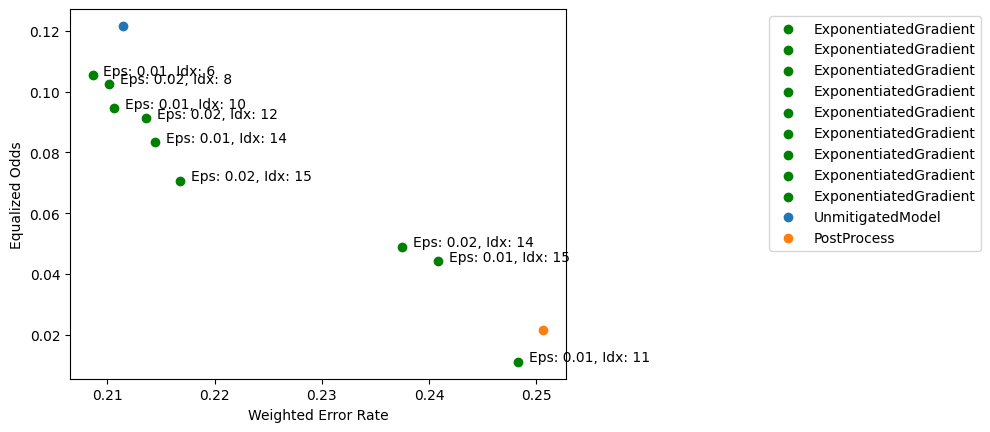

In [ ]:
for index, row in performance_df_masked.iterrows():
    bal_error, eq_odds_diff = row["balanced_error"], row["equalized_odds"]
    epsilon_, index_ = row["epsilon"], row["index"]
    plt.scatter(
        bal_error, eq_odds_diff, color="green", label="ExponentiatedGradient"
    )
    plt.text(
        bal_error + 0.001,
        eq_odds_diff + 0.0001,
        f"Eps: {epsilon_}, Idx: {int(index_)}",
        fontsize=10,
    )
plt.scatter(
    1.0 - balanced_accuracy_unmitigated,
    equalized_odds_unmitigated,
    label="UnmitigatedModel",
)
plt.scatter(
    1.0 - bal_acc_postprocess, eq_odds_postprocess, label="PostProcess"
)
plt.xlabel("Weighted Error Rate")
plt.ylabel("Equalized Odds")
plt.legend(bbox_to_anchor=(1.85, 1))

In [ ]:
def filter_models_by_unmitigiated_score(
    all_models,
    models_frames,
    unmitigated_score,
    performance_metric="balanced_error",
    fairness_metric="equalized_odds",
    threshold=0.01,
):
    """Filter out models whose performance score is above the desired
    threshold. Out of the remaining model, return the models with the best
    score on the fairness metric.

    Parameters
    ----------
    all_models: Dictionary (Epsilon, Index) mapping (epilson, index number) pairs to a Model object
    models_frames: A DataFrame representing each model's performance and fairness score.
    unmitigated_score: The performance score of the unmitigated model.
    performance_metric: The model performance metric to threshold on.
    fairness_metric: The fairness metric to optimize for
    threshold: The threshold padding added to the :code:`unmitigated_score`.

    """
    # Create threshold based on balanced_error of unmitigated model and filter
    models_filtered = models_frames.query(
        f"{performance_metric} <= {unmitigated_score + threshold}"
    )
    best_row = models_filtered.sort_values(by=[fairness_metric]).iloc[0]
    # Choose the model with smallest equalized_odds difference
    epsilon, index = best_row[["epsilon", "index"]]
    return {
        "model": all_models[epsilon][index],
        "epsilon": epsilon,
        "index": index,
    }

In [ ]:
best_model = filter_models_by_unmitigiated_score(
    all_models,
    models_frames=performance_df,
    unmitigated_score=(1.0 - balanced_accuracy_unmitigated),
    threshold=0.015,
)

print(
    f"Epsilon for best model: {best_model.get('epsilon')}, Index number: {best_model.get('index')}"
)
inprocess_model = best_model.get("model")

Epsilon for best model: 0.02, Index number: 15.0


In [ ]:
y_pred_inprocess = inprocess_model.predict(X_test)

bal_acc_inprocess = balanced_accuracy_score(y_test, y_pred_inprocess)
eq_odds_inprocess = equalized_odds_difference(
    y_test, y_pred_inprocess, sensitive_features=A_test
)

In [ ]:
metricframe_inprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred_inprocess,
    sensitive_features=A_test,
)

array([[<Axes: title={'center': 'balanced_accuracy'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

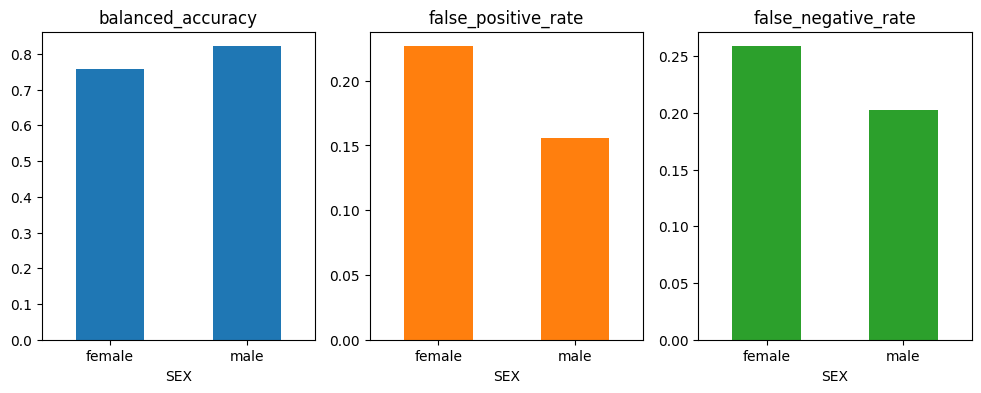

In [ ]:
metricframe_inprocess.difference()[metrics_to_report]

metricframe_inprocess.overall[metrics_to_report]

metricframe_inprocess.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

In [ ]:
metric_error_pairs = [
    ("balanced_accuracy", "balanced_acc_error"),
    ("false_positive_rate", "false_positive_error"),
    ("false_negative_rate", "false_negative_error"),
]


def create_metricframe_w_errors(mframe, metrics_to_report, metric_error_pair):
    mframe_by_group = mframe.by_group.copy()
    for (metric_name, error_name) in metric_error_pair:
        mframe_by_group[metric_name] = mframe_by_group[metric_name].apply(
            lambda x: f"{x:.3f}"
        )
        mframe_by_group[error_name] = mframe_by_group[error_name].apply(
            lambda x: f"{x:.3f}"
        )
        mframe_by_group[metric_name] = mframe_by_group[metric_name].str.cat(
            mframe_by_group[error_name], sep="±"
        )
    return mframe_by_group[metrics_to_report]

In [ ]:
create_metricframe_w_errors(
    metricframe_unmitigated, metrics_to_report, metric_error_pairs
)

metricframe_unmitigated.overall[metrics_to_report]

balanced_accuracy      0.788589
false_positive_rate    0.220497
false_negative_rate    0.202325
dtype: float64

In [ ]:
metricframe_inprocess.overall[metrics_to_report]

create_metricframe_w_errors(
    metricframe_postprocess, metrics_to_report, metric_error_pairs
)

metricframe_postprocess.overall[metrics_to_report]


balanced_accuracy      0.749335
false_positive_rate    0.246056
false_negative_rate    0.255273
dtype: float64